In [20]:
import struct
import random
import os
import numpy as np
import pandas as pd 
import argparse
import logging
import sys
import operator
from hashlib import md5
from reedsolo import RSCodec
from math import ceil
from math import log, floor, sqrt
import random
import json
import numpy as np
from numpy.random import RandomState
import scipy.interpolate as inter
import math
import csv
from Fountain_Helpers import *
from Visual import * 
from FT_class import *
from Model_Helpers import *
from tqdm import tqdm
logging.getLogger().setLevel(logging.INFO)
from scipy import stats
import cv2 as cv
%load_ext autoreload
%autoreload 2

MASK_LENGTH = 32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
class Mask:
    # random mask generator
    def __init__(self, seed, scanner = None, mask_length = 96,withdraw = 0, mask_space_size = 2, fp = None, rp = None):
        self.mask_length = mask_length
        self.mask_space_size = mask_space_size
        self.seed = seed
        self.withdraw = withdraw
        self.scanner = scanner
        if self.scanner == None:
            self.scanner = Scanner()
        self.masks = self.gen_random_masks(4**self.mask_space_size)  
        self.fp = fp
        self.rp = rp
        self.hit_indexes = []
        self.encode_result = []
        self.fail = []
        
    def gen_random_mask(self):
        return random_dna(self.mask_length)
    
    def gen_random_masks(self,mask_num = 16):
        self.refresh()
        self.masks = [self.gen_random_mask() for i in range(mask_num)]
        return self.masks
        
    def refresh(self):
        random.seed(self.seed)
        for i in range(self.withdraw):
            random.randint(0,255)
        
    def assemble(self,dna,mask_index):
        dna = num_to_dna(mask_index,self.mask_space_size) + dna
        if self.rp != None and self.fp != None:
            return self.fp + dna + self.rp
        else: return dna
    
    def encode_dna(self,dna):
        temp = []
        for (i,m_dna) in enumerate(self.masks):
            masked_dna = self.assemble(xor_dna(dna,m_dna),i)
            temp.append(masked_dna)
            if(self.scanner.Pass(masked_dna)):
                return i, masked_dna, 0
        #all fail
        masked_dna, max_homo= self.scanner.select_best(temp)
#         self.hit_indexes.append(-1)
#         self.encode_result.append(masked_dna)
        return -1, masked_dna, max_homo

    
    def encode(self,dnas):
        self.encode_result = []
        self.hit_indexes = []
        self.fail = []
        for j,dna in enumerate(dnas):
            hit_index, masked_dna, max_homo = self.encode_dna(dna)
            self.hit_indexes.append(hit_index)
            self.encode_result.append(masked_dna)
            if(hit_index == -1):
                self.fail.append([j,masked_dna,max_homo])
        return self.encode_result, self.hit_indexes
    
    def decode(self,dnas):
        self.re_dnas = []
        for re_dna in dnas:
            mask_index = dna_to_int_array(re_dna[:self.mask_space_size])[0]
            re_dna = xor_dna(re_dna[self.mask_space_size:],self.masks[mask_index])
            self.re_dnas.append(re_dna)
        return self.re_dnas

def data_to_dnas(data,bar_code_length = 8):
    dnas = []
    for i,d in enumerate(data):
        d = num_to_dna(i,bar_code_length) + byte_to_dna(d)
        dnas.append(d)
    return dnas

def dnas_to_data(dnas,chunk_num,bar_code_length = 8):
    data_chunks = [b'' for b in range(chunk_num)]
    for dna in dnas:
        index = dna_to_num(dna[:bar_code_length])
        payload = dna_to_byte(dna[bar_code_length:])
        data_chunks[index] = payload
    return b''.join(data_chunks)

def index_len(chunk_num):
    return int(sqrt(sqrt(chunk_num))) + 1

In [22]:
B_2_N = {
    'A': 0,
    'C': 1,
    'G': 2,
    'T': 3
}

def dna_to_num(dna):
    return sum([num * 4**i for i,num in enumerate([B_2_N[b] for b in dna][::-1])])

In [23]:
data, file_size, chunk_num = pre_process('content.rar',20)
index_l = index_len(chunk_num)
dnas = data_to_dnas(data,index_l)

s = Scanner()
m = Mask(87211,withdraw = 102,scanner = s, mask_length = 100, mask_space_size=3)

encode_result = m.encode(dnas)[0]
re_dnas = m.decode(encode_result)

re_data = dnas_to_data(dnas,chunk_num,index_l)
with open('mreturn.rar','wb') as f:
        f.write(re_data)

In [24]:
max([s.Gc(dna) for dna in encode_result])

0.5444444444444444

In [25]:
sum([s.gc_pass(dna) == False for dna in encode_result])

0

In [26]:
C = {
    'A': (0,0.4,1),
    'T': (0.8,0.2,0.2),
    'G': (1,0,0.8),
    'C': (0,1,0.4),
    'D': (1,1,1),
    'I': (0.8,0.8,0.4),
    'B': (0,0,0)
}

class dna_painter:
    def __init__(self,W = 10,H = 10):
        self.W = W
        self.H = H
        self.Line_width = int(H/3) + 1
        self.Line_spacing = int(H/2) + 1
        
    def rec(self,img,x,n,c,ins = 0):
        if ins == 1:
            cv.rectangle(img,(x*self.W,n*self.H),(x*self.W+self.W-1,n*self.H+self.H-1),C['I'],-1)
        else:
            cv.rectangle(img,(x*self.W,n*self.H),(x*self.W+self.W-1,n*self.H+self.H-1),c,-1)
    
    def line(self,img,x,n,l):
        cv.line(img,(x*self.W, n*self.H + self.Line_spacing),(x*self.W + l*self.W-1,n*self.H + self.Line_spacing),(1,1,1),self.Line_width)
    
    def draw_dna(self,img,dna,row = 0):
        for i,base in enumerate(dna):
            self.rec(img,i,row,C[base])
            
    def draw_text(self,img,text,x,n,c = (1,1,1)):
        
        cv.putText(img, text, (x * self.W,n * self.H+3), cv.FONT_HERSHEY_COMPLEX, 0.6, c, 1)

    def draw_dnas(self,dna_array,src = 'dna.png'):
        img = np.zeros([self.H*(len(dna_array) * 2 + 2),len(dna_array[0])*self.W,3])
        for i in range(len(dna_array)):
            self.draw_dna(img,dna_array[i],i*2)
        plt.imsave(src,img)
        
        return plt.imshow(img)
    
    def draw_dnas_with_marks(self,dna_array,src = 'dna_repeat.png', scanner = None):
        color = lambda b: (0,1,0) if b == True else (1,0,0)  
        self.scanner = scanner
        if scanner == None:
            self.scanner = Scanner()
        gcs = [[self.scanner.Gc(dna), self.scanner.gc_pass(dna)] for dna in dna_array]
        homos = [self.scanner.scan_repeats(dna,True) for dna in dna_array] 
        # get gc and rp
        
        img = np.zeros([self.H*(len(dna_array) * 2),(len(dna_array[0])+11)*(self.W),3])
        #init image
        
        for i in range(len(dna_array)):
            self.draw_dna(img,dna_array[i],i*2)
            for homo in homos[i]:
                l = homo[1]
                start = homo[2]
                self.line(img,start,i*2 + 1,l)
            self.draw_text(img,str(gcs[i][0])[:4],len(dna_array[0]) + 1, i*2+1, color(gcs[i][1]))
            if (homos[i] != []):
                self.draw_text(img,'rej',len(dna_array[0]) + 6, i*2+1, color(False))
            else:
                self.draw_text(img,'pas',len(dna_array[0]) + 6, i*2+1, color(True))
        plt.imsave(src,img)
        
        return plt.imshow(img)

    def draw_error(self,img,errors,row,num):
        for error in errors:
            x = error[0]
            typ = error[1]
            to = error[2]
            if(typ == '-'):
                to = 'D'
            if(typ != '+'):
                self.rec(img,x,row,C[to])
            else:
                self.rec(img,x,row,C[to],1)
        

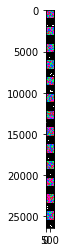

In [30]:

p = dna_painter()
p.draw_dnas_with_marks([d for d in encode_result][:50])
p.draw_dnas_with_marks([d for d in dnas],'ori.png')
#p.draw_dnas(m.masks)

In [312]:
max([scanner.Gc(dna) for dna in encode_result])

0.5444444444444444

In [6]:
class Scanner:
    def __init__(self,max_repeat = 3, gc_interval = [0.45,0.55]):
        self.max_repeat = max_repeat
        self.gc_interval = gc_interval
        
    def scan_repeats(self,dna,record_position = False):
        repeats = []
        prv = dna[0]
        r_num = 1
        for i,c in enumerate(dna[1:]):
            if prv == c:
                r_num += 1
            else:
                if(r_num > self.max_repeat):
                    if(record_position):
                        repeats.append([prv,r_num,i-r_num+1])
                    else:
                        repeats.append([prv,r_num])
                r_num = 1
                prv = c

        if(r_num > self.max_repeat): 
                    if(record_position):
                        repeats.append([prv,r_num,i-r_num+1])
                    else:
                        repeats.append([prv,r_num])
        return repeats
    
    def max_repeats(self,dna):
        rs = self.scan_repeats(dna)
        if rs == []: return 0
        else: return max([r[1] for r in rs])
        
    def repeats_point(self,dna):
        rs = self.scan_repeats(dna)
        if rs == []: return 0
        else:
            return sum([r[1] / (self.max_repeat + 1) for r in rs])

    def Gc(self,dna):
        gc = dna.count('G') + dna.count('C')
        l = len(dna)
        return float(gc) / l
    
    def gc_pass(self,dna):
        if self.gc_interval[0]  < self.Gc(dna) < self.gc_interval[1]:
            return True
        else:
            return False
    
    def Pass(self,dna,with_primer = False):
        if self.gc_pass(dna) and self.repeats_point(dna)  == 0:
            return True
        else:
            return False
    
    def ave_gc(self,dnas):
        return sum([self.Gc(dna) for dna in dnas])/len(dnas)

    def rp_total(self,dnas):
        return(sum([self.repeats_point(dna) for dna in dnas]))

    def Entropy(self,labels, base=4):
        # 计算概率分布
        labels = list(labels)
        probs = pd.Series(labels).value_counts() / len(labels)
        # 计算底数为base的熵
        logging.debug(probs)
        en = stats.entropy(probs, base=base)
        return en
    
    def select_best(self,dnas):
        min_rp = 10000
        best_dna = dnas[0]
        for dna in dnas:
            if(self.gc_pass(dna)):
                if self.repeats_point(dna) < min_rp:
                    min_rp = self.repeats_point(dna)
                    best_dna = dna
        return best_dna,min_rp
                
        



('GAGACCGTCGTAAAACCATAGACCTTCCTACGAGGTGCTGGGCCCGAGAATCATGCGCATCATCTCATTTGTAAACTTGTGAATCTACTCTGCATTATCA',
 1.0)

In [22]:
def mask(dna,m_dnas):
    for (i,m_dna) in enumerate(m_dnas):
        s_dna = xor_dna(dna,m_dna)
        #logging.debug(s_dna)
        if Pass(s_dna)[0]:
            return i,s_dna
    
    rp_min = 100
    r_dna = dna
    for (i,m_dna) in enumerate(m_dnas):
        s_dna = xor_dna(dna,m_dna)
        gc,rp = Pass(s_dna)[1:]
        if(0.45 < gc < 0.55):
            if rp < rp_min:
                rp_min = rp
                r_dna = s_dna
                
    return -1,[r_dna,rp_min]

In [23]:
file_name = '200M.pdf'
chunk_size = 32
f_in, f_size, chunk_num = pre_process(file_name, chunk_size)
dnas = [byte_to_dna(chunk) for chunk in f_in]

In [24]:
random.seed(81231)
m_dnas = []
for i in range(10000):
    m_dnas.append(random_dna(128))
#m_dnas = m_dnas[:400]
#m_dnas = ['A' * 128]+ m_dnas
#m_dnas = ['A' * 128] + ['C' * 128] + ['A' * 64 + 'C' * 64] + ['A' * 64 + 'T' * 64] + m_dnas 

In [26]:
ar = []
for dna in tqdm(dnas[:100]):
    s_dnas = [xor_dna(dna,m_dna) for m_dna in m_dnas]
    ar.append(analyze(s_dnas))
ar

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


NameError: name 'homo_pass' is not defined

In [270]:
# Mask Test
pos_arr = []
s_dnas = []
f_dnas = []
rps = []
f_pos = []
for i,dna in tqdm(enumerate(dnas)):
    pos, s_dna = mask_with_primer(dna)
    if pos == -1:
            s_dna, rp = (s_dna[0],s_dna[1])
            rps.append(rp)
            f_pos.append(i)
            f_dnas.append(s_dna)
    pos_arr.append(pos)
    #s_dnas.appned(s_dna)
len(dnas),pos_arr.count(-1),sum(pos_arr)+len(dnas),(sum(pos_arr)+len(dnas))/len(dnas)
#f_pos,rps,f_dnas

73782it [00:27, 2689.66it/s]


(73782, 3446, 351551, 4.764725813884145)

In [252]:
len(dnas)

73782

In [274]:

r = []
for m_dna in tqdm(m_dnas[:10]):
    s_dnas = [xor_dna(m_dna,dna) for dna in dnas]
    r.append([gc_out_range(s_dnas),rp_total(s_dnas),pass_num(s_dnas),ave_gc(s_dnas),Gc(m_dna),repeats_point(m_dna),Entropy(m_dna),m_dna])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.30s/it]


,gc out range,total homo,pass num,ave gc,mask gc,mask homo,mask entropy
gc out range,1.000000,0.822542,0.073081,0.306106,-0.282179,0.837580,-0.894056
total homo,0.822542,1.000000,0.506815,0.329278,-0.209578,0.995191,-0.911248
pass num,0.073081,0.506815,1.000000,-0.041542,-0.010491,0.530030,-0.336333
ave gc,0.306106,0.329278,-0.041542,1.000000,-0.850716,0.298385,-0.167657
mask gc,-0.282179,-0.209578,-0.010491,-0.850716,1.000000,-0.225186,0.090899
mask homo,0.837580,0.995191,0.530030,0.298385,-0.225186,1.000000,-0.916055
mask entropy,-0.894056,-0.911248,-0.336333,-0.167657,0.090899,-0.916055,1.000000


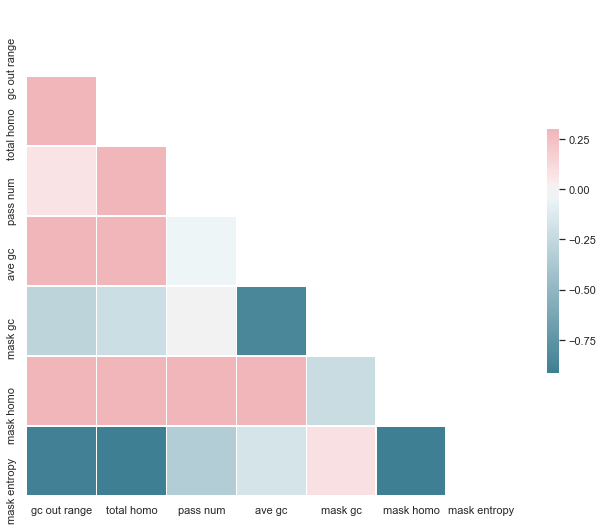

In [275]:
sm = pd.DataFrame([ri[:-1] for ri in r[:300]],columns= ['gc out range','total homo','pass num','ave gc','mask gc','mask homo','mask entropy'])
corr = sm.corr()
heatmap(corr)
corr

In [165]:
sm = np.array([s_rp,m_rp])
cor = np.corrcoef(sm)
cor

array([[1.        , 0.60688296],
       [0.60688296, 1.        ]])

In [276]:
pd.DataFrame(r,columns=['gc','homo cost','pass num','ave gc','mask gc','mask homo cost','mask entropy','mask'])

,gc,homo cost,pass num,ave gc,mask gc,mask homo cost,mask entropy,mask
0,19603,192243.25,13050,0.502761,0.000000,32.00,0.000000,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
1,19603,192243.25,13050,0.497239,1.000000,32.00,0.000000,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2,3862,193622.50,19686,0.500053,0.500000,32.00,0.500000,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
3,19603,190605.75,13042,0.502761,0.000000,32.00,0.500000,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
4,1631,117574.25,13089,0.499713,0.531250,2.75,0.992378,CGCCTGATAGGGGGGGCTTCGTTTCCCTGCGCATTATGTAATTTCA...
5,2848,117259.25,10520,0.498559,0.460938,3.00,0.994429,CTAGTGAAGAAAGTAGGCGCCCCTCACAGTTCGATTGCTTACTGTG...
6,2155,123791.25,10820,0.500165,0.562500,2.00,0.992378,TACCTTTTCCAAGTTGTGCGGGCCAGCCACCAGCAGACCACTTCAA...
7,2455,107280.25,14467,0.498454,0.476562,0.00,0.996727,ATTGGCCTGCTTGGAAGCTAGTCAGATTGTGTGCTATTATAATCAT...
8,1666,124374.00,10516,0.501462,0.515625,2.00,0.990488,GGGAACTAACGGAACGCAGCACCGTTGGAGGGTAGTGGAGACCGGG...
9,1511,119259.50,11708,0.499683,0.453125,2.25,0.989361,CGTGTTTCTGTAATTTTTCTCAATTATGCCGCGGCAGGTTACCTCA...


In [45]:
gcs = [Gc(dna) for dna in dnas]
rps = [repeats_point(dna) for dna in dnas]

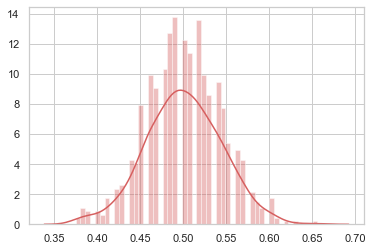

In [46]:
rp_dist = []
rp_dist.append(rps.count(0))
for i in range(10):
    rp_dist.append(sum([i < rp <= i+1 for rp in rps]))

gc_dist = []
gc_intervals = [[ 0.05 *i, 0.05 *(i+1)] for i in range(8)] + [[0.4 + 0.02 *i, 0.4 + 0.02 *(i+1)] for i in range(10)] + [[ 0.6+0.05 *i, 0.6+0.05 *(i+1)] for i in range(8)] 
for interval in gc_intervals:
    gc_dist.append(sum([interval[0] < gc < interval[1] for gc in gcs]))

#line(gc_dist,[itv[0] for itv in gc_intervals])
hist(gcs)